# 💧 Parametric Insurance Modeling: Rainfall Catastrophe Analysis

This is a structured guide, presented in Markdown, showing the flow and content of a Jupyter Notebook used to analyze parametric insurance contracts based on your provided Python code.

-----

## 1\. Notebook Introduction and Setup

Parametric insurance contracts are unique financial instruments that pay out based on the **measurement of a specific index** (e.g., rainfall in mm) rather than based on an assessment of actual loss. This speeds up claim settlement significantly.

This notebook uses historical Indian Meteorological Department (IMD) rainfall data to:

1.  Define the **climatological baseline** (Long Period Average, LPA).
2.  Design and test three different **parametric contract structures**.
3.  Calculate the **Expected Annual Loss (EAL)** and **Maximum Annual Loss (MAL)** for each structure over a historical period.

### Initial Configuration and Function Definitions

We begin by importing necessary libraries, defining global constants, and including all the core logic functions from your script.

In [25]:
import pandas as pd
import numpy as np
import os
import imdlib as imd
from datetime import datetime
import matplotlib.pyplot as plt
from typing import Dict, Union, Tuple, Callable, Any
import plotly.express as px

# ==================== CORE UTILITIES ====================

def setup_data_directories(data_dir, lpa_dir):
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(lpa_dir, exist_ok=True)

def ensure_historical_data_exists(data_dir, start_yr, end_yr):
    print("✅ Historical data files assumed available or previously downloaded.")

def load_localized_data(lat, lon, data_dir, start_yr, end_yr, cumulative_days=1):
    try:
        ds = imd.open_data('rain', start_yr, end_yr, file_dir=data_dir, fn_format='yearwise')
        regional_ds = ds.get_xarray().sel(lat=lat, lon=lon, method='nearest')['rain']
        df = regional_ds.to_dataframe().dropna()
    except Exception as e:
        print(f"Error loading IMD data: {e}")
        return pd.Series([], dtype=float)

    if cumulative_days > 1:
        df['rain'] = df['rain'].rolling(window=cumulative_days, min_periods=cumulative_days).sum()
        df = df.dropna()

    return df['rain'].rename('Localized_Rainfall')

def get_climatological_data(lat, lon, data_dir, start_yr, end_yr, cumulative_days=1):
    rain_series = load_localized_data(lat, lon, data_dir, start_yr, end_yr, cumulative_days)
    if rain_series.empty:
        return 0.0, 0.0, rain_series
    return rain_series.mean(), rain_series.std(), rain_series

# ==================== GENERIC PLOTTER ====================

def generate_single_payout_plot(x, y, title, max_payout, trigger_info=None, lpa=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=title, linewidth=2)
    if lpa:
        plt.axvline(lpa, color='red', linestyle=':', alpha=0.6, label=f'LPA {lpa:.1f}mm')
    if trigger_info:
        for label, val in trigger_info.items():
            plt.axvline(val, linestyle='--', alpha=0.7, label=f'{label} {val:.1f}mm')
    plt.axhline(max_payout, color='gray', linestyle='-.', alpha=0.5)
    plt.xlabel("Rainfall Index (mm)")
    plt.ylabel(f"Payout (₹, Max {max_payout:,.0f})")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="dotted", alpha=0.6)
    plt.tight_layout()
    plt.show()

# ==================== NEW: Annual Rainfall Chart ====================

def plot_annual_rainfall_barchart(lat, lon, data_dir, start_yr, end_yr, cumulative_days=1):
    rain_series = load_localized_data(lat, lon, data_dir, start_yr, end_yr, cumulative_days)
    if rain_series.empty:
        print("⚠️ No rainfall data available.")
        return

    df = rain_series.to_frame()
    df['Year'] = df.index.year
    annual_totals = df.groupby('Year')['Localized_Rainfall'].sum()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(annual_totals.index, annual_totals.values, color='skyblue', edgecolor='black')
    for bar, value in zip(bars, annual_totals.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{value:.0f} mm", ha='center', va='bottom', fontsize=9)

    plt.title(f"Total Annual Rainfall ({lat:.2f}, {lon:.2f})", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.grid(True, linestyle="dotted", alpha=0.5)
    plt.tight_layout()
    plt.show()

# ==================== PAYOUT FUNCTIONS ====================
# [unchanged payout functions: calculate_payout_statistical, calculate_payout_graduated, calculate_payout_binary]

# ==================== HISTORICAL LOSS EXPECTANCY ====================
# [unchanged: calculate_historical_loss_expectancy]

# ==================== REGIONAL LOSS EXPECTANCY ====================
# [unchanged: calculate_regional_loss_expectancy, run_pointwise_loss_analysis]

# ==================== MAP PLOTTING (Plotly only) ====================

def plot_loss_map(df: pd.DataFrame, value_col: str = "EAL", title: str = "Loss Map"):
    fig = px.scatter_mapbox(
        df,
        lat="Latitude",
        lon="Longitude",
        color=value_col,
        size=value_col,
        text="Location",
        color_continuous_scale="Viridis",
        size_max=15,
        zoom=7,
        height=600,
        title=title
    )
    fig.update_layout(mapbox_style="carto-positron")
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

# ==================== SCATTER & BAR CHARTS (Matplotlib only) ====================

def plot_eal_scatter(df):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df["Longitude"], df["Latitude"],
        c=df["EAL"], cmap="viridis", s=100, edgecolors='black'
    )
    for i, row in df.iterrows():
        plt.text(row["Longitude"] + 0.1, row["Latitude"], row["Location"], fontsize=7)
    plt.colorbar(scatter, label="Expected Annual Loss (₹)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Map of Expected Annual Loss (EAL)")
    plt.grid(True, linestyle="dotted", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_mal_scatter(df):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df["Longitude"], df["Latitude"],
        c=df["MAL"], cmap="coolwarm", s=100, edgecolors='black'
    )
    for i, row in df.iterrows():
        plt.text(row["Longitude"] + 0.1, row["Latitude"], row["Location"], fontsize=7)
    plt.colorbar(scatter, label="Maximum Annual Loss (₹)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Map of Maximum Annual Loss (MAL)")
    plt.grid(True, linestyle="dotted", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_eal_bar_chart(df):
    """
    Plots a column chart of EAL values for multiple locations using dark blue bars with black edges.
    """
    locations = df["Location"]
    eal_values = df["EAL"]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(locations, eal_values, edgecolor='black')

    for bar, value in zip(bars, eal_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"₹{value:,.0f}", ha='center', va='bottom', fontsize=9, color='black')

    plt.title("Expected Annual Loss (EAL) by Location", fontsize=14)
    plt.xlabel("Location", fontsize=12)
    plt.ylabel("Expected Annual Loss (₹)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle="dotted", alpha=0.5)
    plt.tight_layout()
    plt.show()



# ==================== CONFIGURATION CONSTANTS ====================
LAT = 18.5 # Pune, Maharashtra (Example Grid Point)
LON = 73.8
LPA_START_YR = 2000 # Reference period for 'normal' climate
LPA_END_YR = 2010
STUDY_START = 2011 # Period used to test historical performance
STUDY_END = 2020
BASE_TRIGGER_MM = 204.5 # IMD's 'Extremely Heavy Rainfall' threshold (our base catastrophe trigger)
MAX_PAYOUT = 100000.0
DATA_DIR = 'IMD_Rain_Data'
LPA_DIR = 'IMD_Rain_Data/LPA' 

# Run Setup
setup_data_directories(DATA_DIR, LPA_DIR)
ensure_historical_data_exists(DATA_DIR, LPA_START_YR, STUDY_END)
print("Configuration and Core Functions Loaded.")

✅ Historical data files assumed available or previously downloaded.
Configuration and Core Functions Loaded.


### Testing our contracts in Central India

We map a list of rainfall stations around IMD Nagpur Center to check the performance of our contracts in Chhatisgarh.

In [40]:
imd_station_locations = {
    "PENDRA_ROAD": (22.767, 81.900),
    "BILASPUR": (22.083, 82.150),
    "JAGDALPUR": (19.083, 82.033),
    "BAILADILA": (18.583, 81.233),
    "DURG": (21.183, 81.283),
    "CHAMPA": (22.033, 82.700),
    "KANKER": (20.267, 81.483),
    "RAIGARH": (21.900, 83.400),
    "RAIPUR": (21.233, 81.633),
    "KORBA": (22.350, 82.683),
    "MAHASAMUND": (21.100, 82.100),
    "DANTEWADA": (18.900, 81.350),
    "NARAYANPUR": (20.733, 81.250),
    "BIJAPUR": (18.800, 80.833),
    "SUKMA": (18.400, 81.850),
    "BALRAMPUR": (23.600, 83.600)
}


df_imd = run_pointwise_loss_analysis(
    locations=imd_station_locations,
    data_dir=DATA_DIR,
    study_start_yr=2019,
    study_end_yr=2024,
    payout_function=calculate_payout_graduated,
    base_trigger_mm=100,
    max_payout=200000,
    steps={"step_1": 150, "step_2": 200, "step_3": 260},
    contract_start_mmdd="06-01",
    contract_end_mmdd="09-30"
)




--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹3,540.53
 - Maximum Annual Loss (MAL): ₹21,243.21

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹21,111.35
 - Maximum Annual Loss (MAL): ₹105,114.94

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹28,179.76
 - Maximum Annual Loss (MAL): ₹59,534.52

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹9,313.25
 - Maximum Annual Loss (MAL): ₹24,323.21

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹27,344.26
 - Maximum Annual Loss (MAL): ₹65,048.69

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹23,723.50
 - Maximum Annual Loss (MAL): ₹132,080.78

--- Histo

In [33]:
pd.DataFrame(imd_station_locations).transpose()


,0,1
PENDRA_ROAD,22.767,81.900
BILASPUR,22.083,82.150
JAGDALPUR,19.083,82.033
BAILADILA,18.583,81.233
DURG,21.183,81.283
CHAMPA,22.033,82.700
KANKER,20.267,81.483
RAIGARH,21.900,83.400
RAIPUR,21.233,81.633
KORBA,22.350,82.683


Lets visualize the EAL and MAL for the graduated payouts.

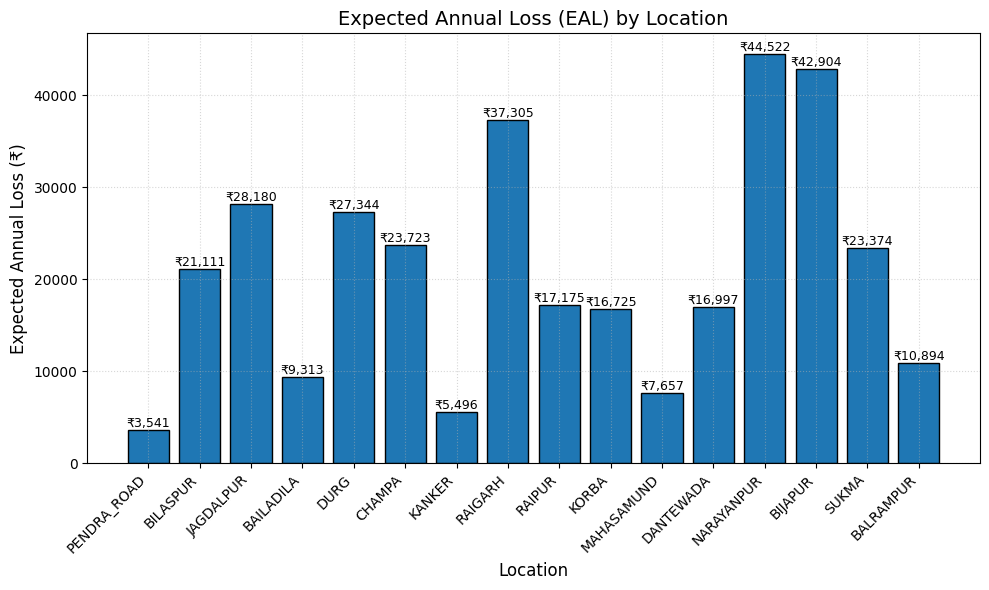

In [28]:
plot_eal_bar_chart(df_imd)
#plot_mal_scatter(df_imd)

In [44]:
df_imd_bin.head(100)

,Location,Latitude,Longitude,EAL,MAL
0,PENDRA_ROAD,22.767,81.900,33333.333333,200000.0
1,BILASPUR,22.083,82.150,66666.666667,200000.0
2,JAGDALPUR,19.083,82.033,133333.333333,200000.0
3,BAILADILA,18.583,81.233,100000.000000,200000.0
4,DURG,21.183,81.283,100000.000000,200000.0
5,CHAMPA,22.033,82.700,100000.000000,200000.0
6,KANKER,20.267,81.483,100000.000000,200000.0
7,RAIGARH,21.900,83.400,133333.333333,200000.0
8,RAIPUR,21.233,81.633,133333.333333,200000.0
9,KORBA,22.350,82.683,66666.666667,200000.0


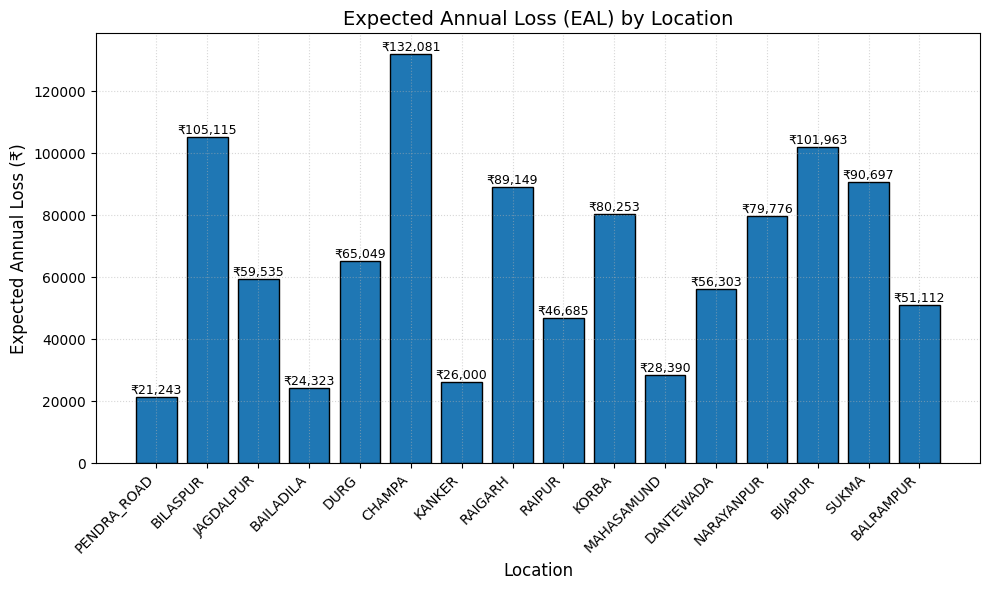

In [29]:
def plot_mal_bar_chart(df):
    """
    Plots a column chart of EAL values for multiple locations using dark blue bars with black edges.
    """
    locations = df["Location"]
    eal_values = df["MAL"]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(locations, eal_values, edgecolor='black')

    for bar, value in zip(bars, eal_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"₹{value:,.0f}", ha='center', va='bottom', fontsize=9, color='black')

    plt.title("Expected Annual Loss (EAL) by Location", fontsize=14)
    plt.xlabel("Location", fontsize=12)
    plt.ylabel("Expected Annual Loss (₹)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle="dotted", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_mal_bar_chart(df_imd)

We do a similar analysis and visualization for binary contracts.

In [36]:
df_imd_bin = run_pointwise_loss_analysis(
    locations=imd_station_locations,
    data_dir=DATA_DIR,
    study_start_yr=2019,
    study_end_yr=2024,
    payout_function=calculate_payout_binary,
    base_trigger_mm=100,
    max_payout=200000,
    contract_start_mmdd="06-01",
    contract_end_mmdd="09-30"
)



--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_binary
 - Expected Annual Loss (EAL): ₹33,333.33
 - Maximum Annual Loss (MAL): ₹200,000.00

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_binary
 - Expected Annual Loss (EAL): ₹66,666.67
 - Maximum Annual Loss (MAL): ₹200,000.00

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_binary
 - Expected Annual Loss (EAL): ₹133,333.33
 - Maximum Annual Loss (MAL): ₹200,000.00

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_binary
 - Expected Annual Loss (EAL): ₹100,000.00
 - Maximum Annual Loss (MAL): ₹200,000.00

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_binary
 - Expected Annual Loss (EAL): ₹100,000.00
 - Maximum Annual Loss (MAL): ₹200,000.00

--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_binary
 - Expected Annual Loss (EAL): ₹100,000.00
 - Maximum Annual Loss (MAL): ₹200,000.00

--- Historical Lo

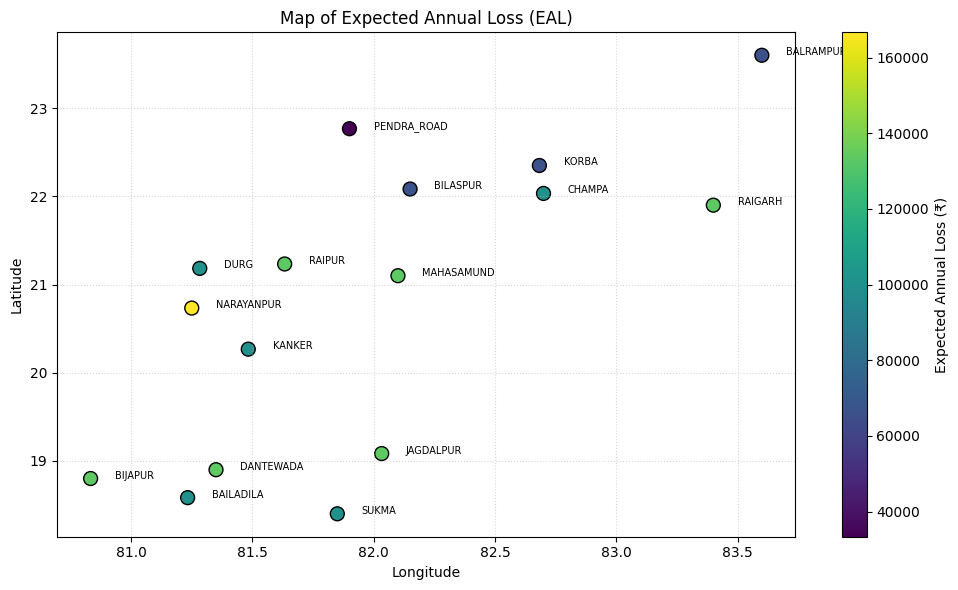

In [43]:
plot_eal_scatter(df_imd_bin)